# Sizing of clock meshes

Original by Lieven Vanderberghe.<br>
Adapted to CVX by Argyris Zymnis, 12/4/2005.<br>
Modified by Michael Grant, 3/8/2006.<br>
Adapted to CVXPY, with cosmetic modifications, by Judson Wilson, 5/26/2014.<br>

Topic References:

* Section 4, L. Vandenberghe, S. Boyd, and A. El Gamal<br>
  "Optimal Wire and Transistor Sizing for Circuits with Non-Tree Topology"

## Introduction

We consider the problem of sizing a clock mesh, so as to minimize the
total dissipated power under a constraint on the dominant time constant.
The numbers of nodes in the mesh is $N$ per row or column (thus $n=(N+1)^2$
in total). We divide the wire into m segments of width $x_i$, $i = 1,\dots,m$
which is constrained as $0 \le x_i \le W_{\mbox{max}}$. We use a pi-model of each wire
segment, with capacitance $\beta_i x_i$ and conductance $\alpha_i x_i$.
Defining $C(x) = C_0+x_1 C_1 + x_2 C_ 2 + \cdots + x_m C_m$ we have that the dissipated
power is equal to $\mathbf{1}^T C(x) \mathbf{1}$. Thus to minimize the
dissipated power subject to a constraint in the widths and a constraint
in the dominant time constant, we solve the SDP
    \begin{array}{ll}
    \mbox{minimize}   & \mathbf{1}^T C(x) \mathbf{1}   \\
    \mbox{subject to} &  T_{\mbox{max}} G(x) - C(x) \succeq 0 \\
                      & 0 \le x_i \le W_{\mbox{max}}.
    \end{array}

## Import and setup packages

In [1]:
import cvxpy as cp
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt

# Show plots inline in ipython.
%matplotlib inline

# Plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

## Helper functions

In [2]:
# Computes the step response of a linear system.
def simple_step(A, B, DT, N):
    n  = A.shape[0]
    Ad = scipy.linalg.expm((A * DT))
    Bd = (Ad - np.eye(n)).dot(B)
    Bd = np.linalg.solve(A, Bd)
    X  = np.zeros((n, N))
    for k in range(1, N):
        X[:, k] = Ad.dot(X[:, k-1]) + Bd;
    return X

## Generate problem data

In [3]:
#
# Circuit parameters.
#

dim=4            # Grid is dimxdim (assume dim is even).
n=(dim+1)**2     # Number of nodes.
m=2*dim*(dim+1)  # Number of wires.
                 #   0 ... dim(dim+1)-1 are horizontal segments
                 #     (numbered rowwise);
                 #   dim(dim+1) ... 2*dim(dim+1)-1 are vertical
                 #     (numbered columnwise)
beta = 0.5       # Capacitance per segment is twice beta times xi.
alpha = 1        # Conductance per segment is alpha times xi.
G0 = 1           # Source conductance.
C0 = np.array([ (      10,     2,     7,     5,     3),
                (       8,     3,     9,     5,     5),
                (       1,     8,     4,     9,     3),
                (       7,     3,     6,     8,     2),
                (       5,     2,     1,     9,    10) ])
wmax = 1        # Upper bound on x.

#
# Build capacitance and conductance matrices.
#

CC = np.zeros((dim+1, dim+1, dim+1, dim+1, m+1))
GG = np.zeros((dim+1, dim+1, dim+1, dim+1, m+1))

# Constant terms.
# - Reshape order='F' is fortran order to match original
#   version in MATLAB code.
CC[:, :, :, :, 0] = np.diag(C0.flatten(order='F')).reshape(dim+1, dim+1,
                                                           dim+1, dim+1, order='F').copy()
zo13 = np.zeros((2, 1, 2, 1))
zo13[:,0,:,0] = np.array([(1, 0), (0, 1)])
zo24 = np.zeros((1, 2, 1, 2))
zo24[0,:,0,:] = zo13[:, 0, :, 0]
pn13 = np.zeros((2, 1, 2, 1))
pn13[:,0,:,0] = np.array([[1, -1], [-1, 1]])
pn24 = np.zeros((1, 2, 1, 2))
pn24[0, :, 0, :] = pn13[:, 0, :, 0]

for i in range(dim+1):
    # Source conductance.
    # First driver in the middle of row 1.
    GG[int(dim/2), i, int(dim/2), i, 0] = G0
    for j in range(dim):
        # Horizontal segments.
        node = 1 + j + i * dim
        CC[j:j+2, i, j:j+2, i, node] = beta * zo13[:, 0, :, 0]
        GG[j:j+2, i, j:j+2, i, node] = alpha * pn13[:, 0, :, 0]
        # Vertical segments.
        node = node + dim * ( dim + 1 )
        CC[i, j:j+2, i, j:j+2, node] = beta * zo24[0, :, 0, :]
        GG[i, j:j+2, i, j:j+2, node] = alpha * pn24[0, :, 0, :]

# Reshape for ease of use.
CC = CC.reshape((n*n, m+1), order='F').copy()
GG = GG.reshape((n*n, m+1), order='F').copy()

#
# Compute points the tradeoff curve, and the three sample points.
#

npts    = 50
delays  = np.linspace(50, 150, npts)
xdelays = [50, 100]
xnpts   = len(xdelays)
areas   = np.zeros(npts)
xareas  = dict()

## Solve problem and display results

Point 1 of 50 on the tradeoff curve (Tmax = 50.0)
CVXOPT failed, trying robust KKT
Point 2 of 50 on the tradeoff curve (Tmax = 52.04081632653061)
Point 3 of 50 on the tradeoff curve (Tmax = 54.08163265306123)
Point 4 of 50 on the tradeoff curve (Tmax = 56.12244897959184)
Point 5 of 50 on the tradeoff curve (Tmax = 58.16326530612245)
Point 6 of 50 on the tradeoff curve (Tmax = 60.20408163265306)
Point 7 of 50 on the tradeoff curve (Tmax = 62.244897959183675)
Point 8 of 50 on the tradeoff curve (Tmax = 64.28571428571429)
Point 9 of 50 on the tradeoff curve (Tmax = 66.3265306122449)
Point 10 of 50 on the tradeoff curve (Tmax = 68.36734693877551)
Point 11 of 50 on the tradeoff curve (Tmax = 70.40816326530611)
Point 12 of 50 on the tradeoff curve (Tmax = 72.44897959183673)
Point 13 of 50 on the tradeoff curve (Tmax = 74.48979591836735)
Point 14 of 50 on the tradeoff curve (Tmax = 76.53061224489795)
Point 15 of 50 on the tradeoff curve (Tmax = 78.57142857142857)
Point 16 of 50 on the tradeof

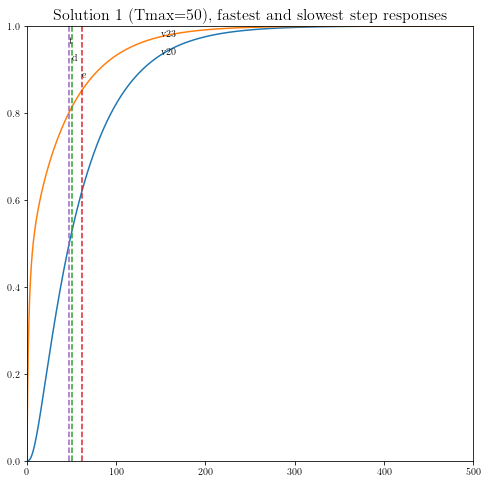

Particular solution 2 of 2 (Tmax = 100)
Solution 2:
Vertical segments:
[[0.2687881  0.04368684 0.17122095 0.133796   0.07360396]
 [0.41346231 0.08016135 0.30642705 0.2224136  0.1484946 ]
 [0.25755998 0.08016077 0.11200259 0.38352317 0.28159768]
 [0.13439419 0.04368697 0.02445701 0.24083502 0.24534599]]
Horizontal segments:
[[ 1.53896782e-09 -5.18600578e-10 -9.75218556e-10 -5.19196383e-10
   1.57176577e-09]
 [ 9.30752726e-10 -9.56673760e-10 -1.35065528e-09 -9.96797753e-10
   1.03852376e-09]
 [ 9.35404466e-10 -9.12219313e-10 -2.22938358e-10 -7.91865186e-10
   1.51304362e-09]
 [ 1.31975762e-09 -8.50790152e-10 -1.39421076e-09 -8.33247519e-10
   1.27680128e-09]]


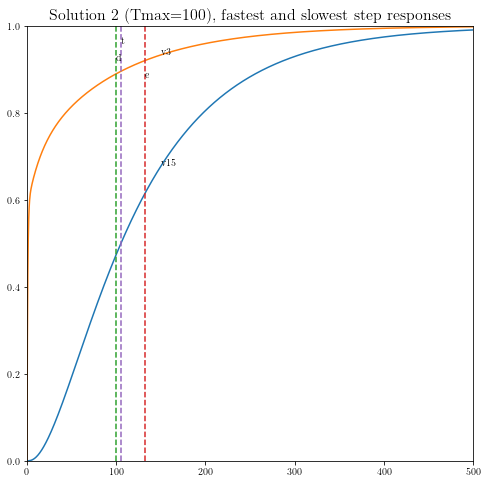

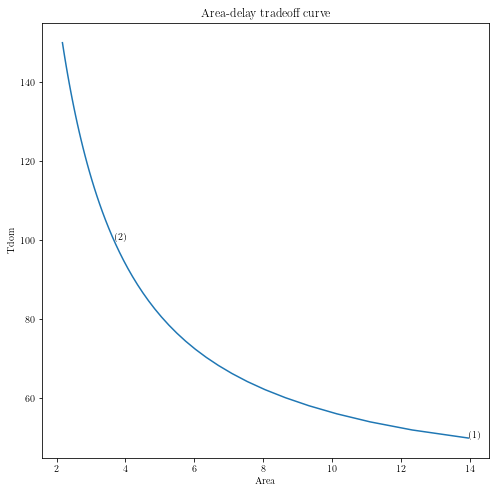

In [4]:
# Iterate over all points, and revisit specific points
for i in range(npts + xnpts):
    # First pass, only gather minimal data from all cases.
    if i < npts:
        delay = delays[i]
        print( ('Point {} of {} on the tradeoff curve ' \
              + '(Tmax = {})').format(i+1, npts, delay))
    # Second pass, gather more data for specific cases,
    # and make plots (later).
    else:
        xi = i - npts
        delay = xdelays[xi]
        print( ('Particular solution {} of {} ' \
              + '(Tmax = {})').format(xi+1, xnpts, delay))

    #
    # Construct and solve the convex model.
    #

    # Variables.
    xt = cp.Variable(shape=(m+1)) # Element 1 of xt == 1 below.
    G = cp.Variable((n,n), symmetric=True)  # Symmetric constraint below.
    C = cp.Variable((n,n), symmetric=True)  # Symmetric constraint below.
    
    # Objective.
    obj = cp.Minimize(cp.sum(C))

    # Constraints.
    constraints = [ xt[0] == 1,
                    G == G.T,
                    C == C.T,
                    G == cp.reshape(GG*xt, (n,n)),
                    C == cp.reshape(CC*xt, (n,n)),
                    delay * G - C == cp.Variable(shape=(n,n), PSD=True),
                    0 <= xt[1:],
                    xt[1:] <= wmax,
                  ]

    # Solve problem (use CVXOPT instead of SCS to match original results;
    # cvxopt produces lower objective values as well, but is much slower)
    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.CVXOPT)
    except cp.SolverError:
        print("CVXOPT failed, trying robust KKT")
        prob.solve(solver=cp.CVXOPT, kktsolver='robust')
            
    if prob.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        raise Exception('CVXPY Error')
    
    # Chop off the first element of x, which is 
    # constrainted to be 1
    x = xt.value[1:] 

    # First pass, only gather minimal data from all cases.
    if i < npts:
        areas[i] = sum(x)
    # Second pass, gather more data for specific cases,
    # and make plots.
    else:
        xareas[xi] = sum(x)

        #
        # Print display sizes.
        #

        print('Solution {}:'.format(xi+1))
        print('Vertical segments:')
        print(x[0:dim*(dim+1)].reshape(dim, dim+1, order='F').copy())
        print('Horizontal segments:')
        print(x[dim*(dim+1):].reshape(dim, dim+1, order='F').copy())

        #
        # Determine and plot the step responses.
        #

        A = -np.linalg.inv(C.value).dot(G.value)
        B = -A.dot(np.ones(n))
        T = np.linspace(0, 500, 2000)
        Y = simple_step(A, B, T[1], len(T))
        indmax = -1
        indmin = np.inf
        for j in range(Y.shape[0]):
            inds = np.amin(np.nonzero(Y[j, :] >= 0.5)[0])
            if ( inds > indmax ):
                indmax = inds
                jmax = j
            if ( inds < indmin ):
                indmin = inds
                jmin = j

        tthres = T[indmax]
        GinvC  = np.linalg.solve(G.value, C.value)
        tdom   = max(np.linalg.eig(GinvC)[0])
        elmore = np.amax(np.sum(GinvC.T, 0))
        plt.figure(figsize=(8, 8))
        plt.plot( T, np.asarray(Y[jmax,:]).flatten(), '-',
                  T, np.asarray(Y[jmin,:]).flatten() )
        plt.plot( tdom   * np.array([1, 1]), [0, 1], '--',
                  elmore * np.array([1, 1]), [0, 1], '--',
                  tthres * np.array([1, 1]), [0, 1], '--' )
        plt.xlim([0, 500])
        plt.ylim([0, 1])
        plt.text(tdom, 0.92, 'd')
        plt.text(elmore, 0.88, 'e')
        plt.text(tthres, 0.96, 't')
        plt.text( T[600], Y[jmax, 600], 'v{}'.format(jmax+1))
        plt.text( T[600], Y[jmin, 600], 'v{}'.format(jmin+1))
        plt.title(('Solution {} (Tmax={}), fastest ' \
                    + 'and slowest step responses').format(xi+1, delay), fontsize=16)
        plt.show()

#
# Plot the tradeoff curve.
#

plt.figure(figsize=(8, 8))
ind = np.isfinite(areas)
plt.plot(areas[ind], delays[ind])
plt.xlabel('Area')
plt.ylabel('Tdom')
plt.title('Area-delay tradeoff curve')
# Label the specific cases.
for k in range(xnpts):
    plt.text(xareas[k], xdelays[k], '({})'.format(k+1))
plt.show()